## Importing Libraries

In [4]:
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import norm, describe
from scipy.optimize import curve_fit


# Simulating fractional Brownian motion (fBm)

In [5]:
# set process parameters
q = 11
N = 2**q + 1 #number of datapoints
M = 2*N - 2
delta = 0.002
print("q: %d, N: %d, M: %d" % (q, N, M))

q: 11, N: 2049, M: 4096


## $(n+1)^G + \frac{(n-1)^G - 2nG}{2}$

In [6]:
# define functions
def fbc(n,G):
    return ((n+1)**G + np.abs(n-1)**G - 2*n**G)/2.

def lambda_func(H,N):
    M = 2*N - 2
    C = np.zeros(M)
    G = 2*H
    for i in np.arange(N):
        C[i] = fbc(i,G) # fill in first N out of M values of C (i=0 to N-1)
    C[N:] = C[1:N-1][::-1]
    return np.real(np.fft.fft(C))**0.5

In [7]:
noise = np.random.normal(size=(M))

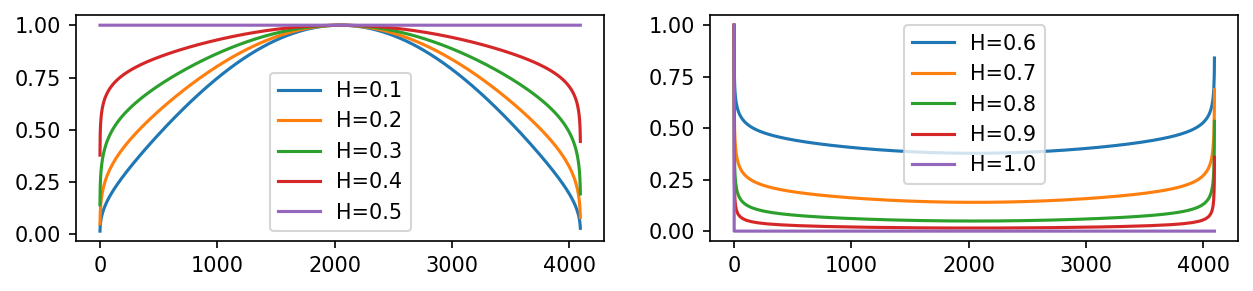

In [8]:
plt.figure(dpi = 150, figsize = (10,2))

for i in range(5):
    plt.subplot(121)
    H = i*0.1 + 0.1
    lambda_function = lambda_func(H, 2049)
    plt.plot(lambda_function/lambda_function.max(), ls = '-', label = "H=%.1f" % H)
    plt.legend()

    plt.subplot(122)
    H = i*0.1 + 0.6
    lambda_function = lambda_func(H, 2049)
    plt.plot(lambda_function/lambda_function.max(), ls = '-', label = "H=%.1f" % H)
    plt.legend()
    
plt.show()

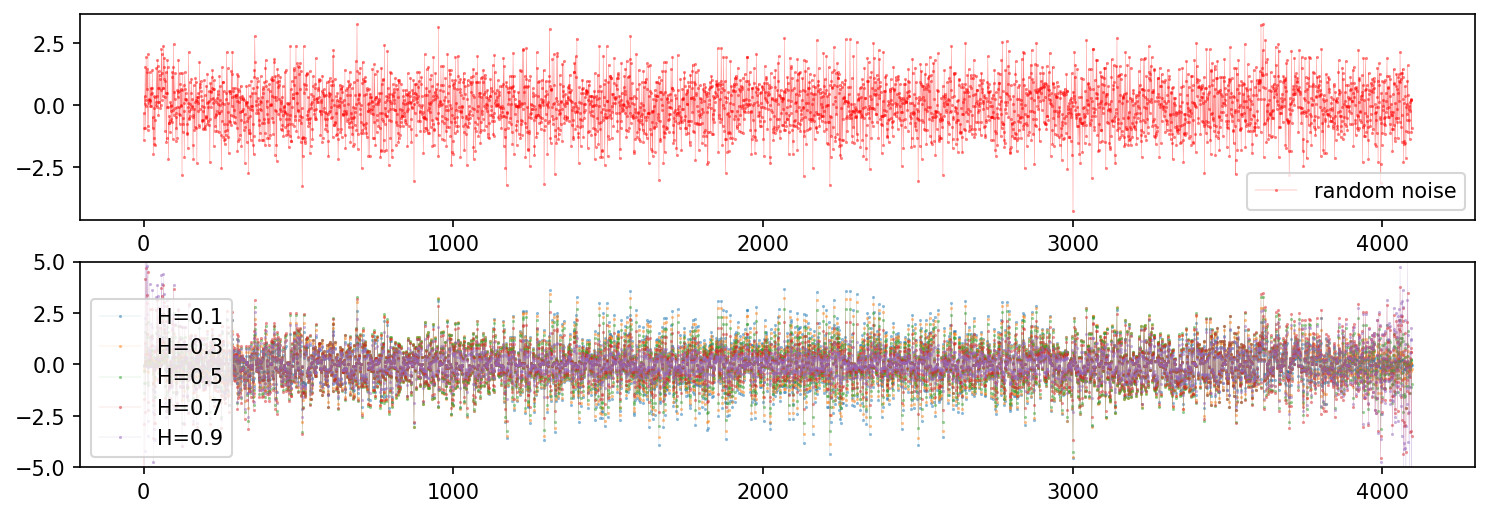

In [9]:
plt.figure(dpi = 150, figsize = (12,4))
plt.subplot(211)
plt.plot(noise, 'r.-', label = "random noise", lw = 0.2, alpha = 0.5, ms = 1)
plt.legend()

for i in range(5):
    plt.subplot(212)
    H = i*0.2 + 0.1
    lambda_function = lambda_func(H, 2049)*noise
    plt.plot(lambda_function, '.-', label = "H=%.1f" % H, lw = 0.1, alpha = 0.5, ms = 1)
    plt.ylim(-5,5)
    plt.legend()

plt.show()

[0.1 0.3 0.5 0.7 0.9]


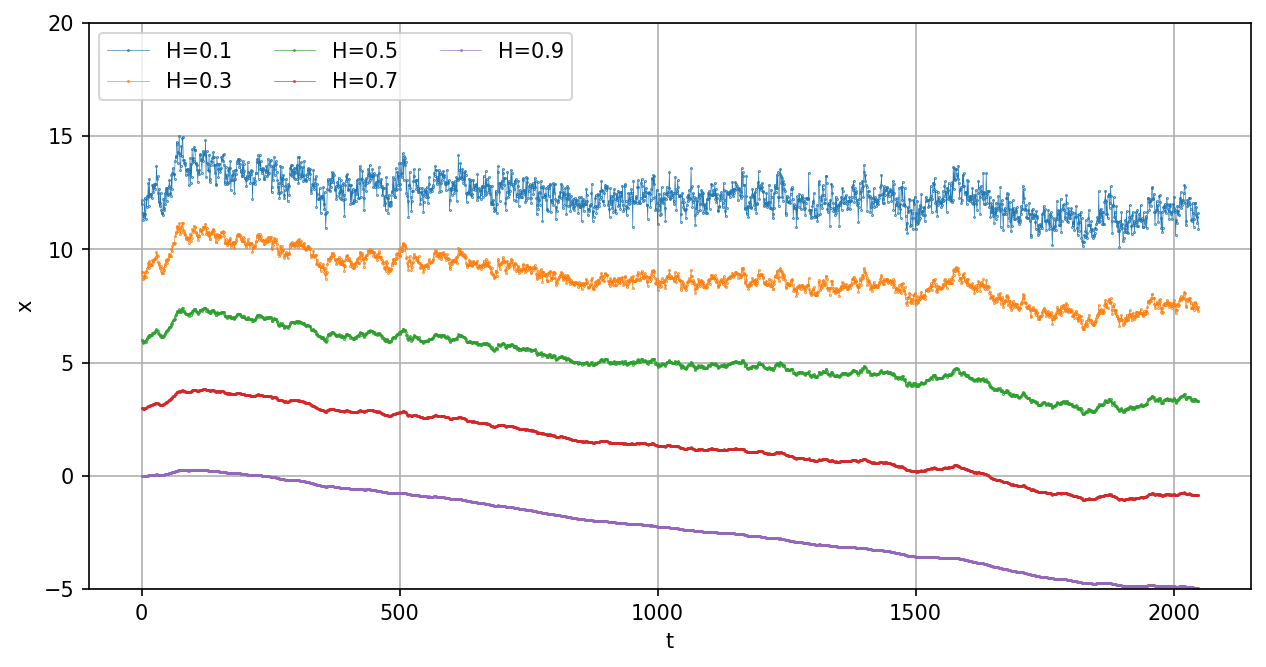

In [10]:
# initialize
fGnsamples = np.zeros((5,N))

# generate fractional Gaussian noise samples
for i in np.arange(5):
    H = 0.2*(i+1) - 0.1
    lambda_res = lambda_func(H,N)
    a = np.fft.ifft(noise)*lambda_res
    b = np.real(np.fft.fft(a))
    fGnsamples[i,0] = 15-3*(i+1)            # apply offset in starting value for visualization
    fGnsamples[i,1:N] = delta**H*b[0:N-1]

# take cumulative sums to get the fractional Brownian motion samples
fBmsamples = np.transpose(np.cumsum(fGnsamples,axis=1)) # cumulative sum over each row

# get values of H
Hval = (np.arange(5) + 1)*0.2 - 0.1
print(Hval)

# plot fractional Brownian motion samples
plt.figure(dpi = 150
           , figsize = (10,5))
plt.grid()
for i in np.arange(len(Hval)):
    plt.plot(fBmsamples[:,i], label="H=%.1f" % Hval[i], marker = '.', ls = '-', lw = 0.3, ms = 0.7)
    plt.ylim(-5, 20)
    plt.legend(loc="upper left", ncol=3)
    plt.xlabel("t")
    plt.ylabel("x")

## Generating fBm samples

In [11]:
def fBm_generator(noise):
    # initialize
    fGnsamples = np.zeros((5,N))

    # generate fractional Gaussian noise samples
    for i in np.arange(5):
        H = 0.2*(i+1) - 0.1
        lambda_res = lambda_func(H,N)
        a = np.fft.ifft(noise)*lambda_res
        b = np.real(np.fft.fft(a))
        fGnsamples[i,0] = 15-3*(i+1)            # apply offset in starting value for visualization
        fGnsamples[i,1:N] = delta**H*b[0:N-1]

    # take cumulative sums to get the fractional Brownian motion samples
    fBmsamples = np.transpose(np.cumsum(fGnsamples,axis=1)) # cumulative sum over each row
    return fBmsamples

In [12]:
np.random.seed(seed=17)
n_samp = 5
# Initialize array to hold the noise samples
noise_samp = np.zeros((M, n_samp))
for i in range(n_samp):
    noise = np.random.normal(size=(M))
    noise_samp[:,i] = noise

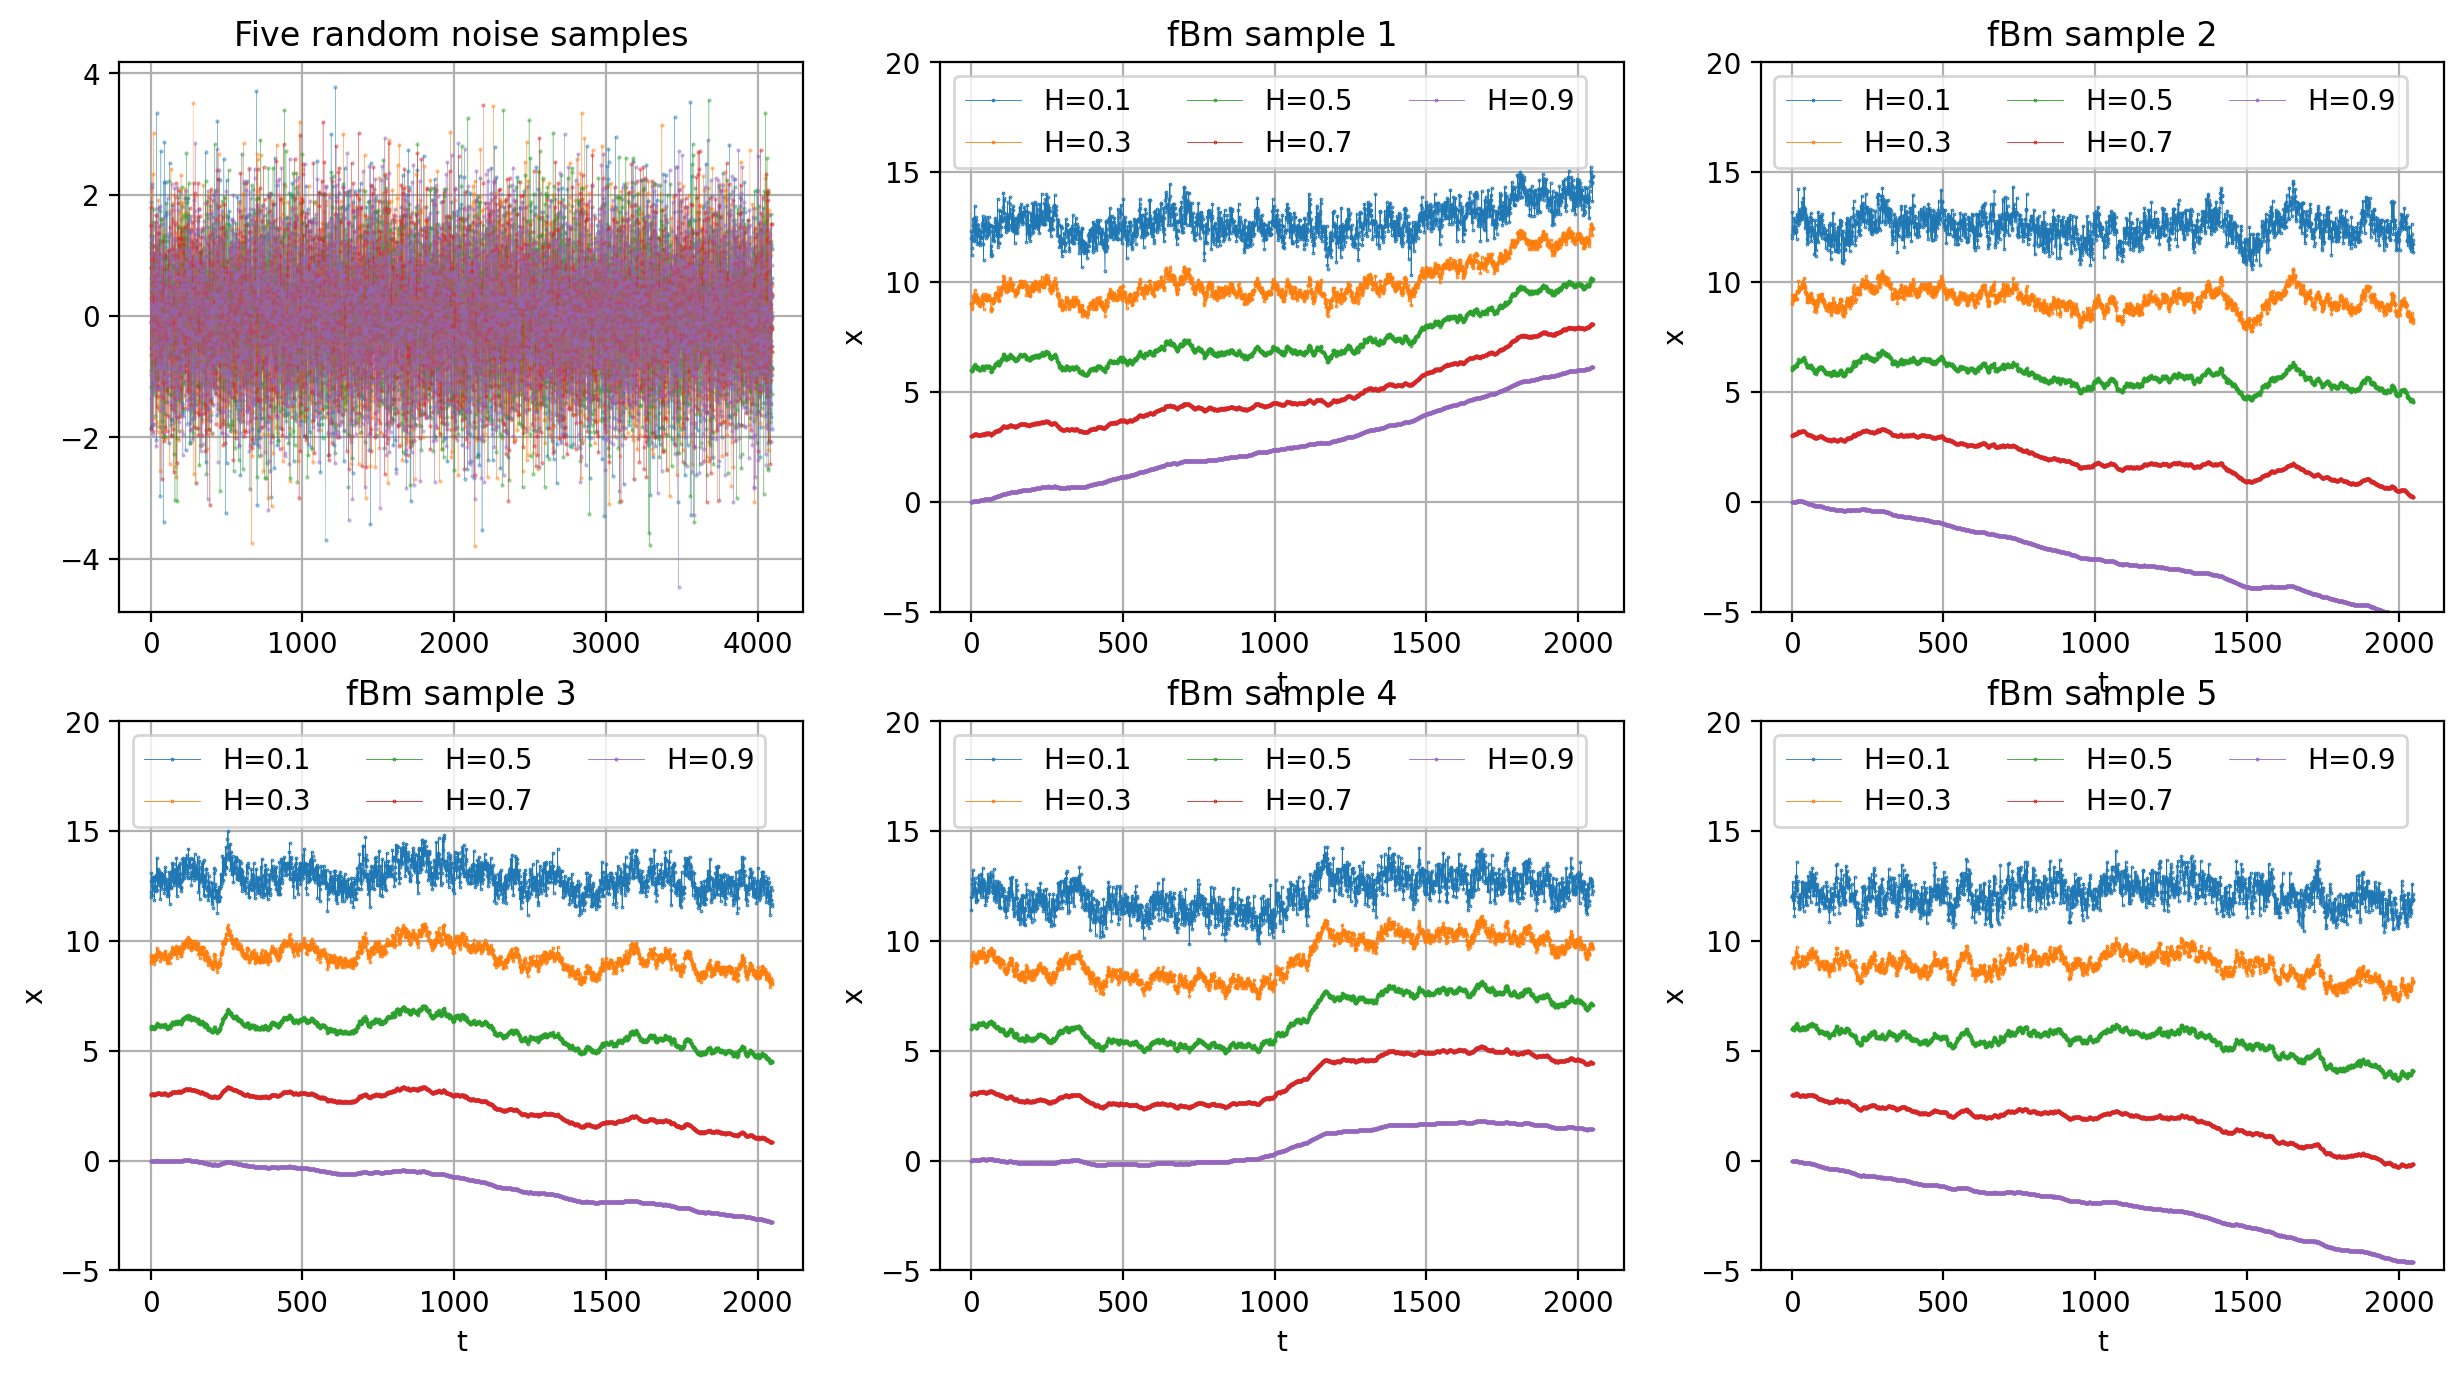

In [13]:
plt.figure(dpi = 200, figsize = (15,8))

plt.subplot(2,3,1)
plt.title("Five random noise samples")
plt.plot(noise_samp, '.-', lw = 0.2, alpha = 0.5, ms = 1)

# Initialize list to hold the fBm samples
fBm_simulations = []

for i, noise in enumerate(noise_samp.T):
    fBmsamples = fBm_generator(noise)
    fBm_simulations.append(fBmsamples)
    plt.grid()
    plt.subplot(2,3,i+2)
    for j in np.arange(len(Hval)):
        plt.title("fBm sample " + str(i+1))
        plt.plot(fBmsamples[:,j], label="H=%.1f" % Hval[j], marker = '.', ls = '-', lw = 0.3, ms = 0.7)
        plt.ylim(-5, 20)
        plt.xlabel("t")
        plt.ylabel("x")
        plt.legend(loc="upper left", ncol=3)
plt.show()

## Calculating PDFs

###  Pre-defined functions

In [14]:
def get_sample_dx(x, delta):
    x_trunc = x[:-1*delta]
    x_shift = x[delta:]
    dx = x_shift - x_trunc
    return dx

def get_pdf(x, delta, bin_edges, norm=True):
    dx = get_sample_dx(x, delta)
    pdf, junk = np.histogram(dx, bins = bin_edges, density=norm)
    return pdf

def gaussian(x, sigma2, N):
    fac = N/(2.*np.pi*sigma2)**0.5
    return fac*np.exp(-1.*(x)**2/2./sigma2)

# define function that performs fit
def fit_pdf(bin_centers, y, yerr=np.array([]), initial=[1., 1.], maxfev=5000):
    if(len(yerr)==0): # no uncertainties given
        popt, pcov = curve_fit(gaussian, bin_centers, y, initial, maxfev=maxfev)
    else:
        popt, pcov = curve_fit(gaussian, bin_centers, y, initial, sigma=yerr, maxfev=maxfev)
    sigma2, N = popt[0], popt[1]
    err_sigma2, err_N = pcov[0,0]**0.5, pcov[1,1]**0.5
    return sigma2, err_sigma2, N, err_N

In [91]:
len(fBm_simulations)

5

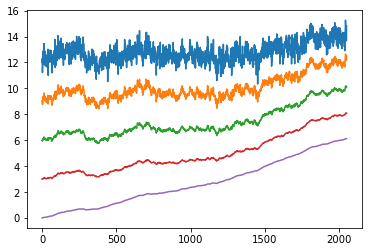

In [93]:
for i in range(5):
    sample = 0
    H_test = Hval[i]
#     plt.plot()
    test_data = fBm_simulations[sample][:, i]
    plt.plot(test_data)
#     tau_test = 1000
#     plt.plot(get_sample_dx(test_data, delta = tau_test), alpha = 0.5)

### Sample 1, H = 0.1, $\tau$ = 30

In [94]:
sample = 0
H_n = 0
H_test = Hval[H_n]
test_data = fBm_simulations[sample][:, H_n]
tau_test = 30

### Obtaining displacements 

In [95]:
test_dx = get_sample_dx(test_data, tau_test)

### Probability Distribution Functions

In [96]:
xlimit = 5.
n_bins = 30
bin_edges = np.linspace(xlimit*-1., xlimit, n_bins+1)
pdf = get_pdf(test_dx, tau_test, bin_edges, norm=False)

### Gaussian Fit

In [97]:
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
sigma2, err_sigma2, N, err_N = fit_pdf(bin_centers, pdf)
xx = np.linspace(xlimit*-1., xlimit)
yy = gaussian(xx, sigma2, N)

### Plotting the fBm PDF and Gaussian fit

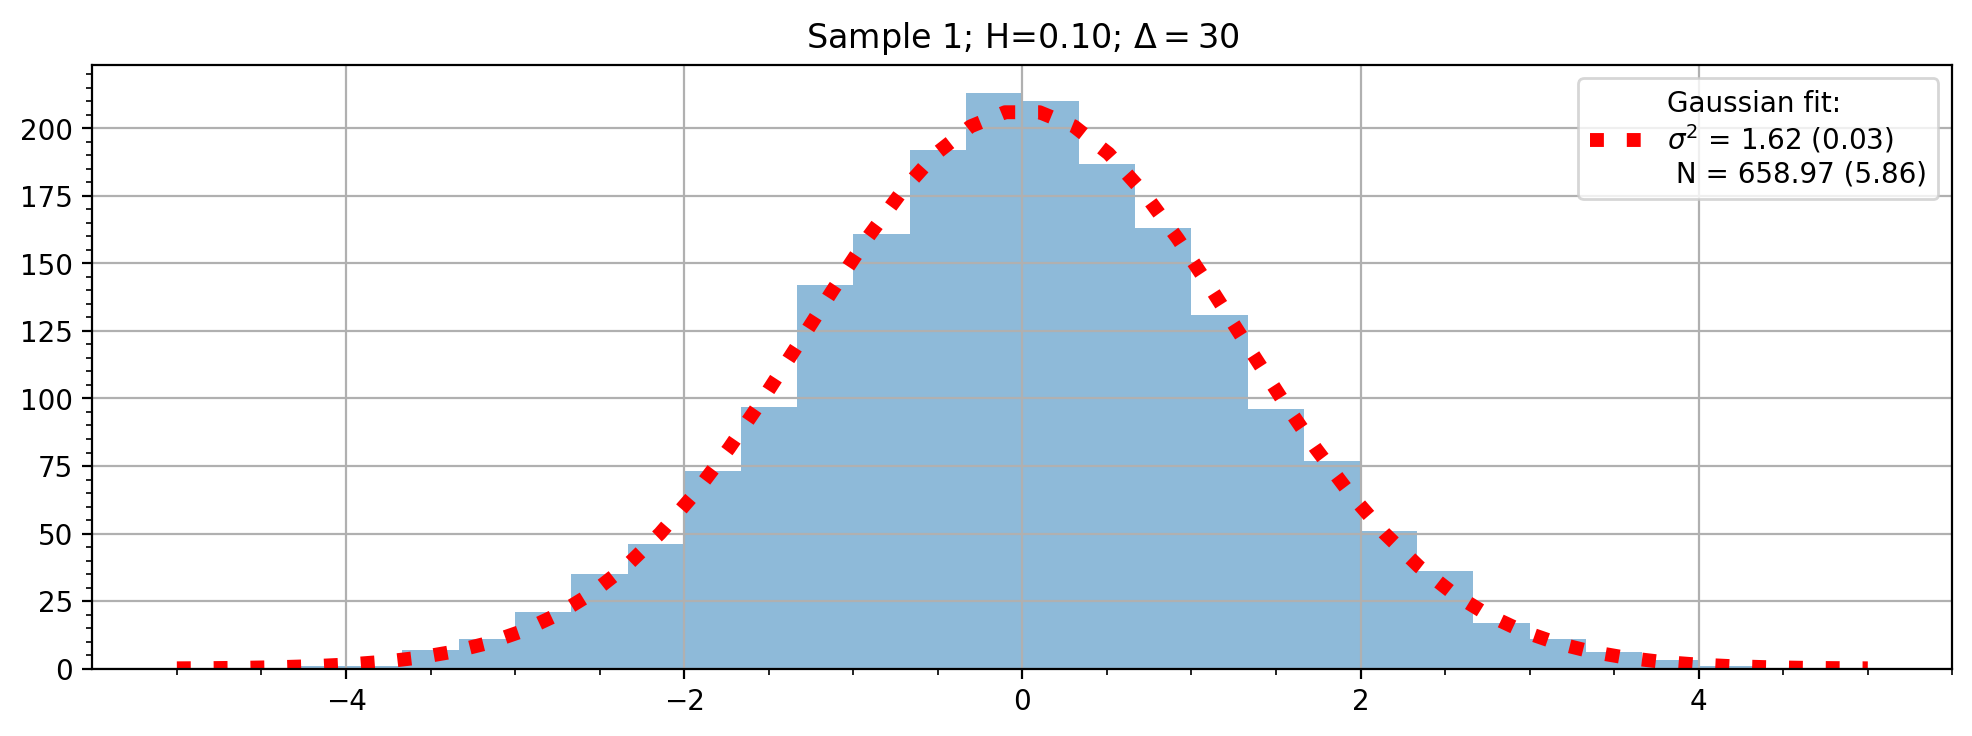

In [98]:
plt.figure(dpi = 200, figsize = (12,4))
plt.grid()
plt.stairs(pdf, bin_edges, fill=True, alpha = 0.5)
plt.plot(xx,yy, 'r:', lw = 5, label = "Gaussian fit: \n" \
        + r"$\sigma^2$ = %.2f (%.2f)" % (sigma2, err_sigma2) \
         + "\n N = %.2f (%.2f)" % (N, err_N))
plt.minorticks_on()
plt.title(r"Sample %d; H=%.2f; $\Delta=%d$" % (sample+1, H_test, tau_test))
plt.legend()

### Automate Plotting

In [104]:
def plot_PDF_fBm(sample, H_n, tau_test, xlimit, n_bins):
    H_test = Hval[H_n]
    test_data = fBm_simulations[sample][:, H_n]
    
    test_dx = get_sample_dx(test_data, tau_test)
    
    bin_edges = np.linspace(xlimit*-1., xlimit, n_bins+1)
    pdf = get_pdf(test_dx, tau_test, bin_edges, norm=True)
    
    bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
    sigma2, err_sigma2, N, err_N = fit_pdf(bin_centers, pdf)
    xx = np.linspace(xlimit*-1., xlimit)
    yy = gaussian(xx, sigma2, N)
    
    plt.grid()
    plt.stairs(pdf, bin_edges, fill=True, alpha = 0.5)
    plt.plot(xx,yy, 'r-', lw = 3, label = "Gaussian fit: \n" \
            + r"$\sigma^2$ = %.2f (%.2f)" % (sigma2, err_sigma2) \
             + "\n N = %.2f (%.2f)" % (N, err_N))
    plt.minorticks_on()
    plt.title(r"Sample %d; H=%.2f; $\Delta=%d$" % (sample+1, H_test, tau_test))
    plt.legend()
#     plt.ylim(0,1)
    

## fBm PDFs for different H

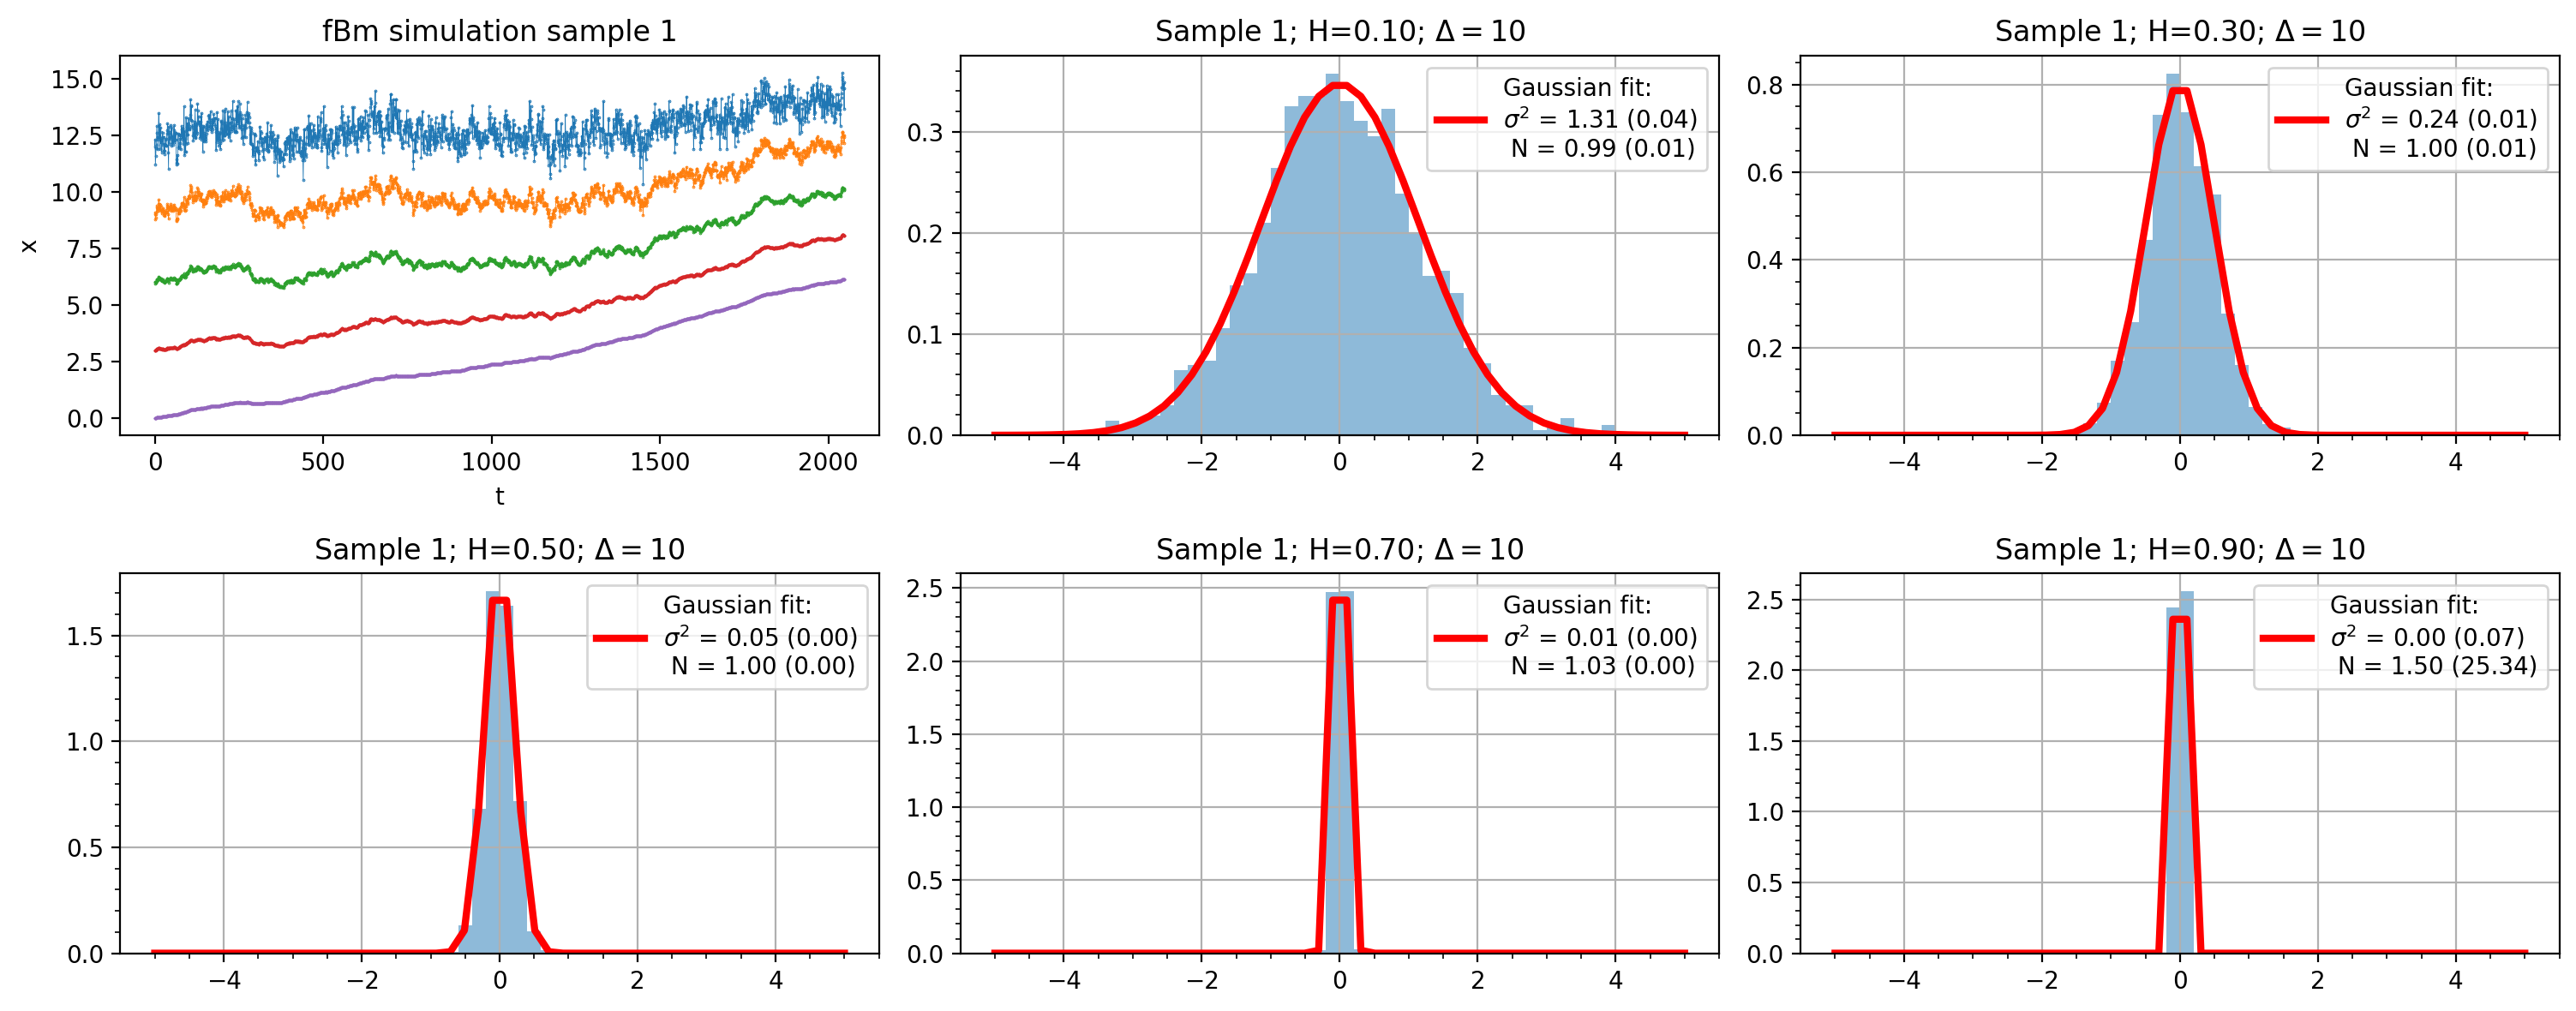

In [106]:
# generate plot for 1 sample
i_samp = 0 # select sample to plot (by index)
plt.figure(dpi = 200, figsize = (15,6))

plt.subplot(2,3,1)
# plt.plot(fBm_simulations[i_samp], label="H=%.1f" % Hval[H_n], marker = '.', ls = '-', lw = 0.3, ms = 0.7)
plt.plot(fBm_simulations[i_samp], marker = '.', ls = '-', lw = 0.3, ms = 0.7)
plt.xlabel("t")
plt.ylabel("x")
plt.title("fBm simulation sample " + str(i_samp+1))
# plt.legend(ncol=3)

for i in np.arange(5):
    plt.subplot(2,3,i+2)
    plot_PDF_fBm(sample = i_samp, H_n = i, tau_test = 10, xlimit = 5, n_bins = 50)
    
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9, hspace=0.5, wspace=0.5)
plt.tight_layout()

## fBm PDFs for different $\tau$

### Setting log-spaced $\tau$ values

In [107]:
n_delta_init = 5 # later, can increase this
logdelta_min = 0
logdelta_max = 3
delta_vals = np.unique(np.floor(np.logspace(logdelta_min, logdelta_max, n_delta_init))).astype(int)
delta_vals

array([   1,    5,   31,  177, 1000])

### fBm Sample 1, H = 0.1, increasing $\tau$ values

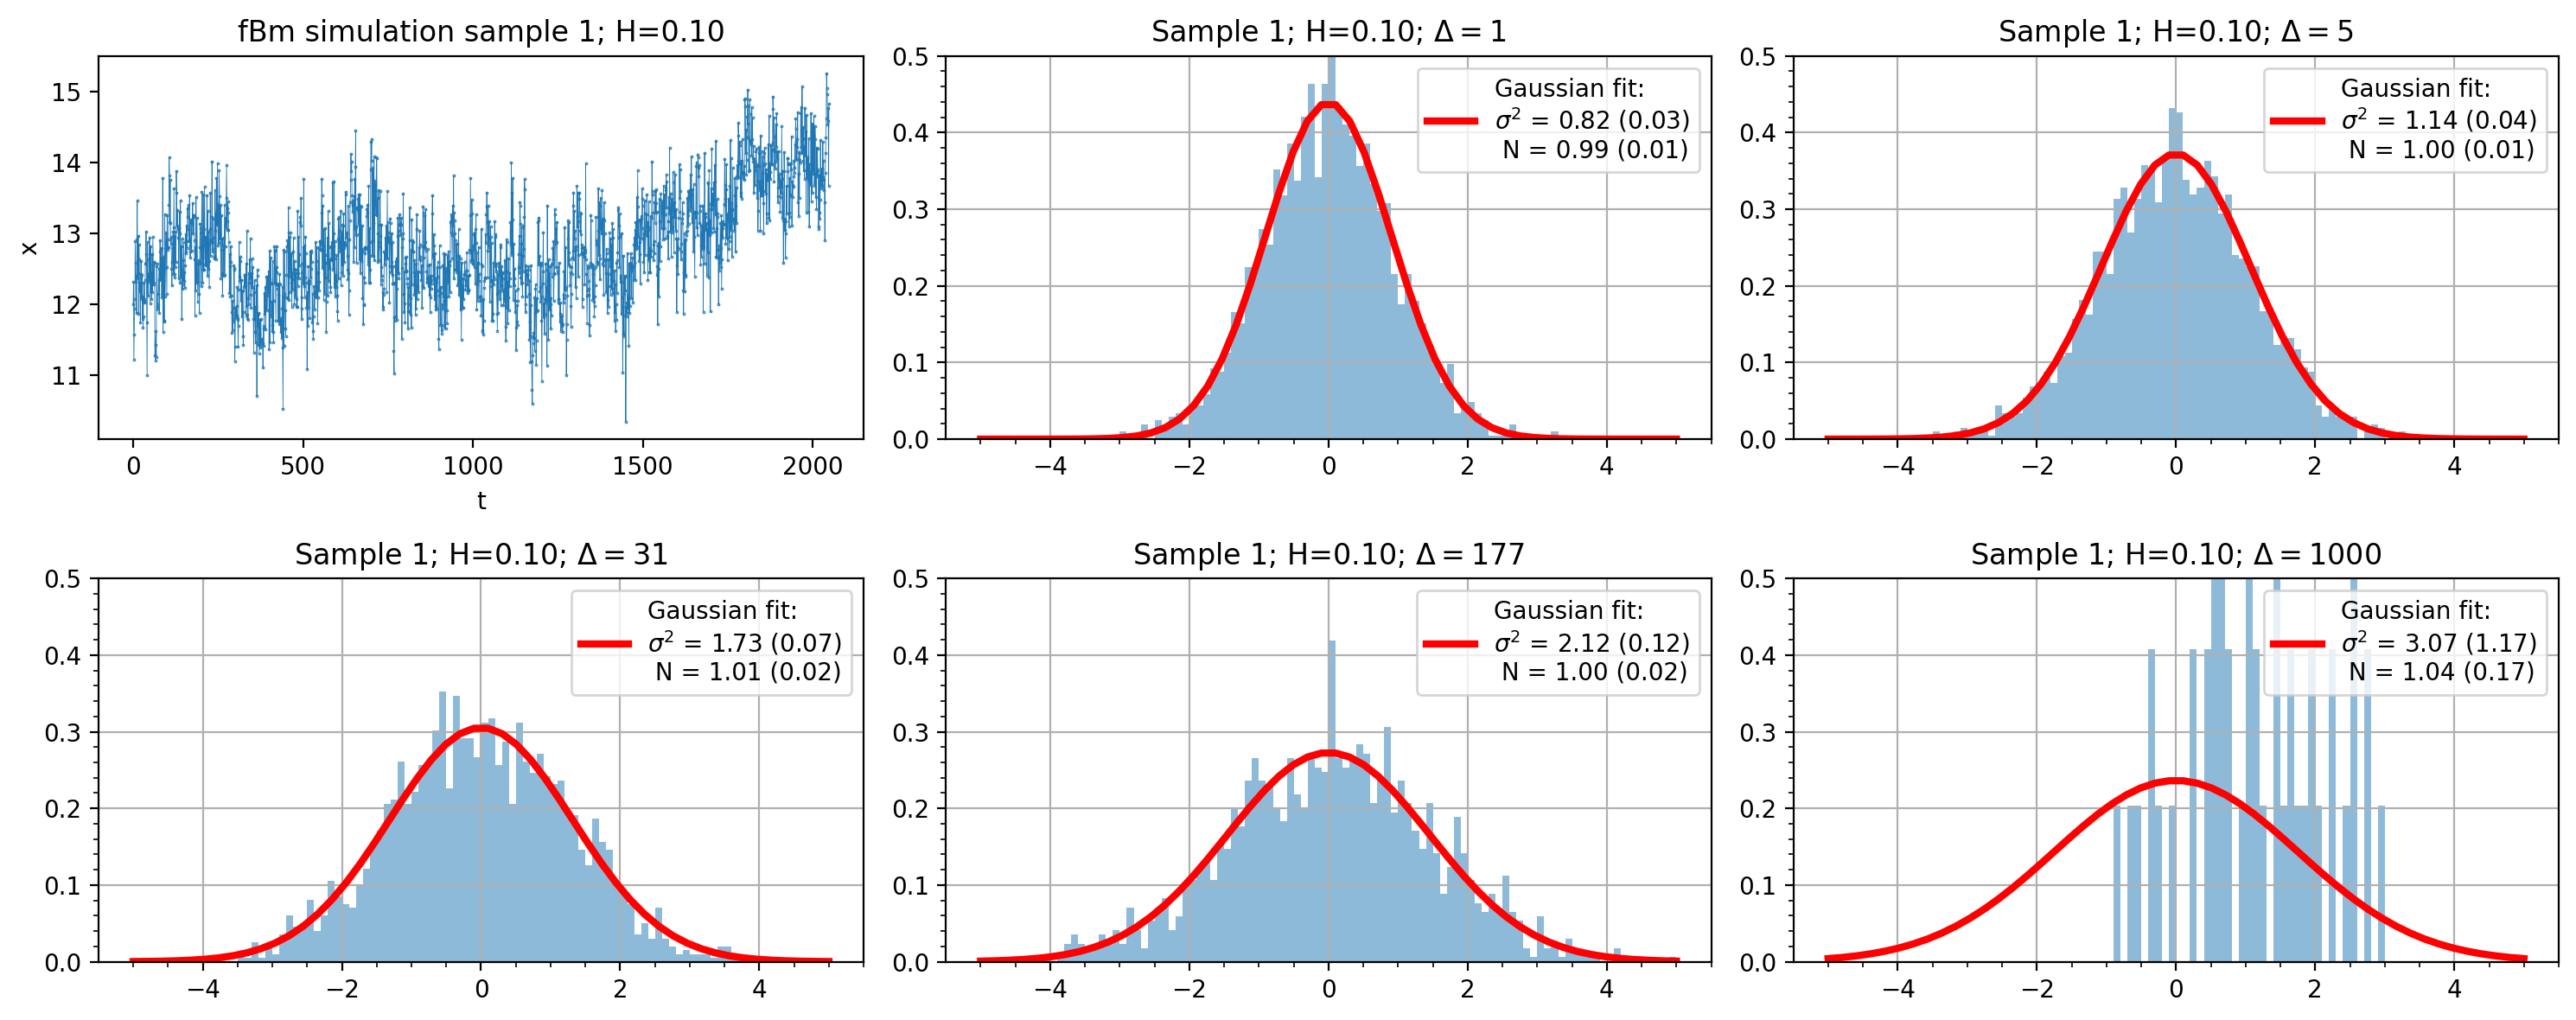

In [120]:
# generate plot for 1 sample
i_samp = 0 # select sample to plot (by index)
H_n = 0

plt.figure(dpi = 200, figsize = (15,6))

plt.subplot(2,3,1)
plt.plot(fBm_simulations[i_samp][:, H_n], marker = '.', ls = '-', lw = 0.3, ms = 0.7)
plt.xlabel("t")
plt.ylabel("x")
plt.title("fBm simulation sample %d; H=%.2f" % (i_samp+1, Hval[H_n]))
# plt.legend(ncol=3)

for i in np.arange(5):
    plt.subplot(2,3,i+2)
    tau = delta_vals[i]
    plot_PDF_fBm(sample = i_samp, H_n = H_n, tau_test = tau, xlimit = 5, n_bins = 100)
    plt.ylim(0, 0.5)
    
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9, hspace=0.5, wspace=0.5)
plt.tight_layout()

### Sample 1, H = 0.9, increasing $\tau$ values

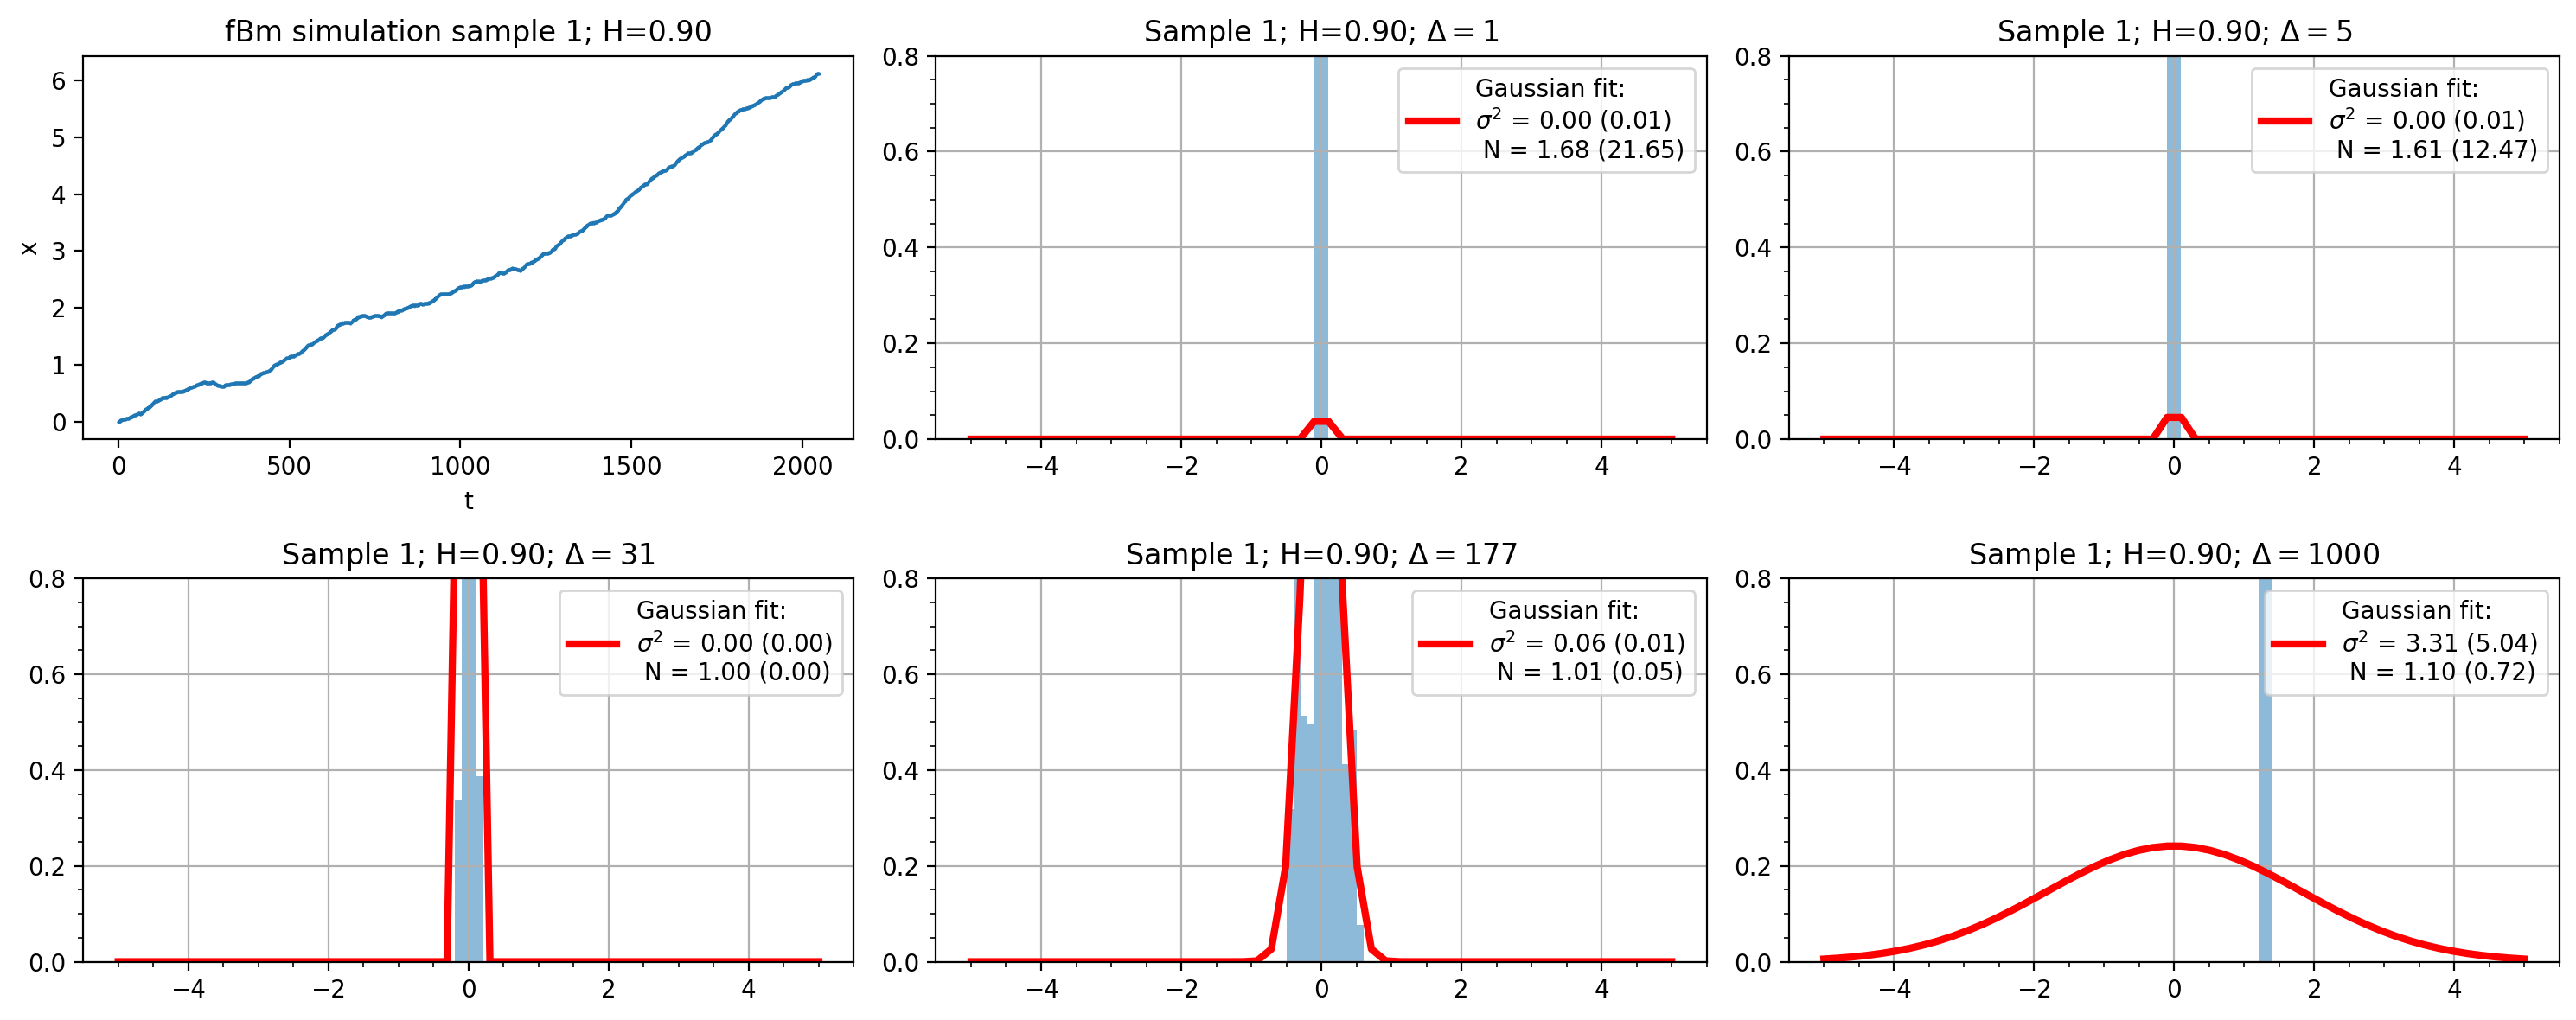

In [122]:
# generate plot for 1 sample
i_samp = 0 # select sample to plot (by index)
H_n = 4

plt.figure(dpi = 200, figsize = (15,6))

plt.subplot(2,3,1)
plt.plot(fBm_simulations[i_samp][:, H_n], marker = '.', ls = '-', lw = 0.3, ms = 0.7)
plt.xlabel("t")
plt.ylabel("x")
plt.title("fBm simulation sample %d; H=%.2f" % (i_samp+1, Hval[H_n]))
# plt.legend(ncol=3)

for i in np.arange(5):
    plt.subplot(2,3,i+2)
    tau = delta_vals[i]
    plot_PDF_fBm(sample = i_samp, H_n = H_n, tau_test = tau, xlimit = 5, n_bins = 100)
    plt.ylim(0,0.8)
    
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9, hspace=0.5, wspace=0.5)
plt.tight_layout()

## Calculating MSD($\tau$) for the five samples

In [125]:
n_delta_init = 20
logdelta_min = 0
logdelta_max = 3
delta_vals = np.unique(np.floor(np.logspace(logdelta_min, logdelta_max, n_delta_init))).astype(int)
delta_vals

array([   1,    2,    4,    6,    8,   12,   18,   26,   37,   54,   78,
        112,  162,  233,  335,  483,  695, 1000])

In [130]:
n_samp = 1
H_n = 0
sample = 0
n_tau = len(delta_vals)
dx_tau = np.empty((M, n_tau))*np.nan

for i, tau in tqdm(enumerate(delta_vals)):
    test_data = fBm_simulations[sample][:, H_n]
    test_dx = get_sample_dx(test_data, tau)
    dx_tau[:len(test_dx), i] = test_dx

18it [00:00, 9585.76it/s]


In [ ]:
msd_tau = np.empty((n_tau, n_samp))*np.nan
for i, tau in enumerate(delta_vals):
    dx2_sum = np.nansum(dx_tau[:, i]**2) # returns sum treating NaNs as zero
    denom = n-delta_vals[i]
    msd_tau[i, i_samp] = dx2_sum/denom